Behavioral Cloning Project - Driving Simulator

In [1]:
import csv
import cv2
import numpy as np
from tqdm import tqdm   #Library for progress bar on for loops.

#Read in the csv file.
lines = []
with open('../data/driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(csvfile)                       #Skip the header
    for line in reader:
        lines.append(line)

#Filling X_train and y_train        
images = []
measurements = []
for line in tqdm(lines):
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = '../data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)    


print(len(images))
print(len(measurements))
print(np.count_nonzero(np.array(measurements))) #This is a measure of the quality of the training data. The higher the better.

100%|██████████| 8036/8036 [00:13<00:00, 593.95it/s]

8036
8036
3675


In [2]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images,measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)
print(X_train.shape)
print(y_train.shape)

(16072, 160, 320, 3)
(16072,)


This image is: <class 'numpy.ndarray'> with dimensions: (160, 320, 3)
Steering angle:  0.1383082


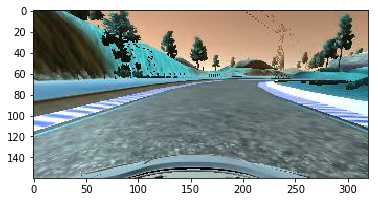

In [3]:
#Plotting an image and its flipped counterpart w/steering angles.
image_number = 4600
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#printing out some stats and plotting
print('This image is:', type(X_train[image_number]), 'with dimensions:', X_train[image_number].shape)
print('Steering angle: ',y_train[image_number])
plt.imshow(X_train[image_number])

Steering angle:  -0.1383082


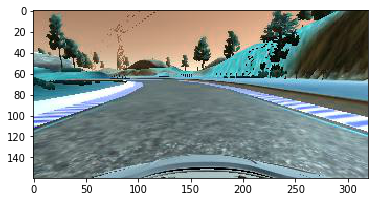

In [4]:
#Flipped image
plt.imshow(X_train[image_number+1])
print('Steering angle: ',y_train[image_number+1])

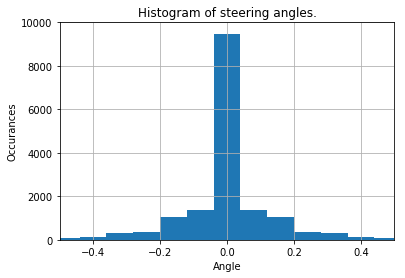

In [5]:
#Histogram of steering angles.
import matplotlib.mlab as mlab

# the histogram of the data
n, bins, patches = plt.hist(y_train, 25)
#n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='green', alpha=0.5)
# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Angle')
plt.ylabel('Occurances')
plt.title('Histogram of steering angles.')
plt.axis([-.5, .5, 0, 10000])
plt.grid(True)

plt.show()

6437


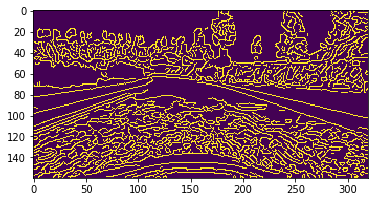

In [6]:
def canny(img):
    low_threshold = 1
    high_threshold = 60
    kernel_size = 5
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    img = cv2.Canny(img, low_threshold, high_threshold)
    return img

from random import randint
image_number = randint(0,8036)
print(image_number)
#image_number = 4612   #Good Curve
image = images[image_number]
edges = canny(image)
plt.imshow(edges)

In [7]:
X_train_canny = []
for image in tqdm(X_train):
    X_train_canny.append(canny(image))

X_train_canny = np.array(X_train_canny)
X_train_canny = X_train_canny.reshape([X_train_canny.shape[0],X_train_canny.shape[1],X_train_canny.shape[2],1])
print(X_train_canny.shape)

100%|██████████| 16072/16072 [00:20<00:00, 800.81it/s]


(16072, 160, 320, 1)


In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Cropping2D
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,1)))
model.add(Cropping2D(cropping=((60,25), (0,0))))

model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))

#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss ='mse', optimizer='adam')
history_object = model.fit(X_train_canny,y_train,validation_split=0.2,shuffle=True, nb_epoch=7,batch_size=512)

Using TensorFlow backend.


Train on 12857 samples, validate on 3215 samples
Epoch 1/7
12857/12857 [==============================] - 294s - loss: 0.0219 - val_loss: 0.0167

dict_keys(['loss', 'val_loss'])


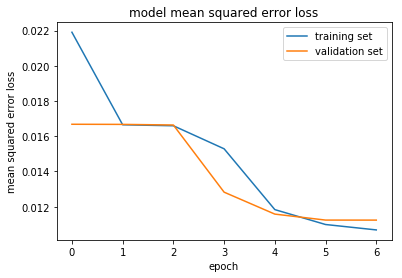

In [9]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [10]:
model.save('../model_rev5_4.h5')